# Lauching a simulation on your local computer

In this notebook, we choose the parameters of the simulation, and the interaction between the particles, and run it. 
This assumes that the C++ files is already compiled through the makefile.

This notebook also needs to be placed in the same folder as the python files.

You might need to install json and subprocess packages, that can be done through the command "pip install subprocess" for instance. 

## 1. Changing the directories names and importing the codes

In [42]:

import json
import subprocess
import numpy as np

from LatticeTools import ReadLatticeParticle
from LatticeTools import DesignLEL
from LatticeTools import LELrepresentation

from System import ReadSeveralSystems

import matplotlib.pyplot as plt

localDirectory = "/Users/lara/Documents/"
        
# We define those directories to run the code from the cluster, this is not needed now 
remoteFromLocalDirectory = "/Users/lara/Documents/LPTMS/"
remoteFromLocalDirectoryScratch = "/Users/lara/Documents/LPTMSscratch/"
remoteDirectory = "/home/lkoehler/"
remoteDirectoryScratch = "/Scratch/lkoehler/"


projectFolderName = "SelfAssembly2/"

## 2. Loading the lattice(s) you want to use

This assumes that the lattice files have been created before 

In [4]:
processLocal = True

if processLocal : 
    directoryLattice = localDirectory+projectFolderName+'/Lattice/'   
else :
    directoryLattice = remoteDirectory+projectFolderName+'/Lattice/'   
    
    
Cubic = ReadLatticeParticle('Cubic', directoryLattice)  
# FCC = ReadLatticeParticle('FaceCenteredCubic', directory)  
# BCC = ReadLatticeParticle('BodyCenteredCubic', directory)  
Triangular = ReadLatticeParticle('Triangular', directoryLattice)  
Square = ReadLatticeParticle('Square', directoryLattice)  
Hexagonal = ReadLatticeParticle('Hexagonal', directoryLattice)  

## 3. We choose the system properties and the simulation parameters

Here we define the name of the simulation, the number of particles, system size
We also choose the annealing procedure, and what will be saved during the simulation

### 3.1 Simulation name


In [106]:
folderResults = '231025Test2'

### 3.2 System geometry, dimension, and composition

Which lattice (triangular, square, cubic)

The size of the lattice in each dimension

How many particles of each type

firstNeighborDistance define on which lattice scales particles interact, this is usually one.
secondNeighborDistance defines on which lattice scales the second neighbor density will be measured (this is related to the renormalization project, and never really used)

In [107]:
lattice = Triangular
# lattice = Hexagonal
# lattice = Square
Nparticles = [50,50] #[50, 50] #[100]  # this is a list of number of particles for each type of particles 
NparticleTypes = len(Nparticles)
Lx = 30
Ly = 30
Lz = 1
firstNeighborDistance = 1
secondNeighborDistance = 2

### 3.3 Annealing  procedure 
The temperature goes from Temperature_start to Temperature_end, with Ntemperatures steps, spread linearly or logarithmically. Per temperature, there is Nsteps_per_T Monte-Carlo steps. 

We can also choose how many snapshots are saved per temperature.

In [109]:
Ntemperatures = 100
Temperature_start = 7
Temperature_end = 1
Type_temperature_ramp = 'linear' #'logarithmic'

Nsteps_per_T = 200*Lx*Ly*Lz #800

N_mes_per_temperatures = 0 #Number of saved snapshot per temperature
# Better to choose it such that Nsteps_per_T/ N_mes_per_temperatures is an integer

### 3.4 Quenching 

You can do the annealing ramp, and then spend some more MC steps at a final temperature, for instance zero

Here you choose which temperature and how much step. If you don't want this, just have 0 quenching steps

In [15]:
Temperature_quenching = 0
Nsteps_quenching = 0#1e3*Lx*Ly*Lz

### 3.5 Statistics

When the final temperatrue is reached, we measure observables, such as the neighbors staitstics, 
over some more Monte-Carlo steps

Here you choose at which temperature the measures are made, and of rhow much steps


In [ ]:

Temperature_statistics = 1
Naverage = 800*Lx*Ly*Lz


### 3.6 Cluster measurements

After the statistics, you measure, on a snapshot, properties of the aggregates geometry, such as size,
number of vacancies, number of surface. Since it is done on the system at one precise time, you can repeat
this measure several time, and run a few MC step in beteween the measurements


In [16]:
Ncluster_measurements = 1
MC_steps_between_measurements = 10*Lx*Ly*Lz



### 3.7 Monte-Carlo types of move

There is three types of moves, mutations, flips, and both at the same type

In [18]:

mutationRate = 0
flipRate = 0.5 
swapRate = 0.5 * 1/len(lattice.orientations)
flipSwapRate = 0.5-swapRate
if flipRate+flipSwapRate+swapRate+mutationRate!=1 :
    print("Careful, the rates don't sum to 1")


### 3.8 Simulation conditions, what to save, where to run



In [19]:
saveSnapshot = True  #will save images of the system
saveEnergies = False
saveMCsuccess = False
saveTemperatures = False

doStatistics = True
saveCovariance = True
saveExtendedScaffold = True

### 3.9 How many annealing will be repeated for the same LEL 


In [110]:
Nsystems= 2

## 4. Choose the interaction matrix 


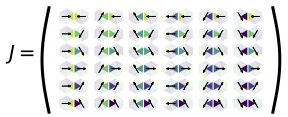

We first load the design class that will allow to genereate the interaction matrices (the LEL) and visualize it.

Caution: the LEL vector given to the C++ programm needs to have the 2-particles sturcture (28 for the hexagons), but also the 1-particle structures (7 for the hexagons). Thus it is a 35-dimensional vector. For the visualization and treatment, only the 28-dimensional vector is used. One needs to convert one to the other depending on the use.

In [26]:
designs = DesignLEL(lattice, NparticleTypes)
visualisation = LELrepresentation(lattice, NparticleTypes)

### 4.1. Isotropic particles 

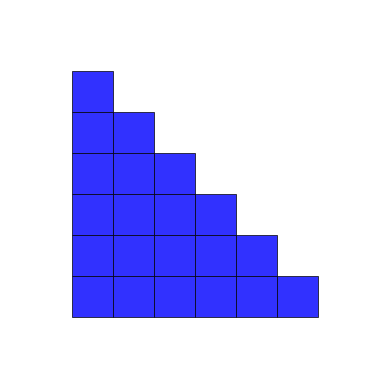

In [34]:
attraction = 2
LEL_isotropic = designs.LEL_sticky_isotropic(attraction) #this is a 35-dimensional vector
LEL_isotropic_short = designs.cut_LEL(LEL_isotropic) #this is a 28-dimensional vector
visualisation.plot_matrix(LEL_isotropic_short, fullMatrix=False, maxi=10)

### 4.2 Several homomeric particles of variable stickiness

Text(0.5, 1.0, 'Homomeric attractive particles. Particle 0 with particle 0')

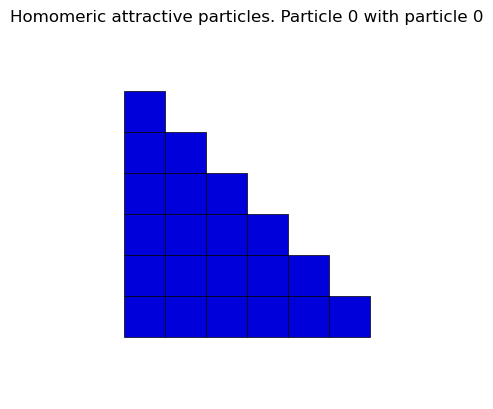

In [54]:
designs = DesignLEL(lattice, 2)
visualization = LELrepresentation(lattice, 2)

attractions = [6,2]
# # attractions = 10
particlesEquivalent = False
repulsion = 2
LEL_homo = designs.LEL_homomeric_particles(attractions, repulsion, particlesEquivalent=particlesEquivalent)
LEL_homo_short = designs.cut_LEL(LEL_homo)

particle1 = 0 #you can change this
particle2 = 0
visualization.plot_matrix(LEL_homo_short, p1=particle1, p2=particle2, fullMatrix=False, maxi=20)
plt.title('Homomeric attractive particles. Particle '+str(particle1)+' with particle '+str(particle2), fontsize=12)


### 4.3 Crystalline LEL

Text(0.5, 1.0, 'Homomeric attractive particles. Particle 1 with particle 1')

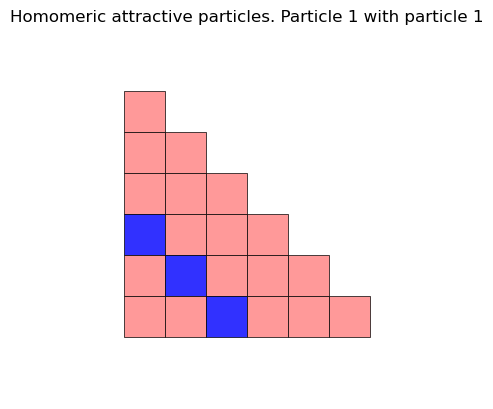

In [57]:
designs = DesignLEL(lattice, 3)
visualization = LELrepresentation(lattice, 3)

attractions = [6,4,1]
particlesEquivalent = True
repulsion = 2
LEL_crystal_homo = designs.LEL_crystal_homomeric(attractions, repulsion, particlesEquivalent=particlesEquivalent)

LEL_crystal_homo_short = designs.cut_LEL(LEL_crystal_homo)

particle1 = 1 #you can change this
particle2 = 1
visualization.plot_matrix(LEL_crystal_homo_short , p1=particle1, p2=particle2, fullMatrix=False, maxi=20)
plt.title('Homomeric attractive particles. Particle '+str(particle1)+' with particle '+str(particle2), fontsize=12)


### 4.4 Random interaction map of chosen affinity and anisotropy

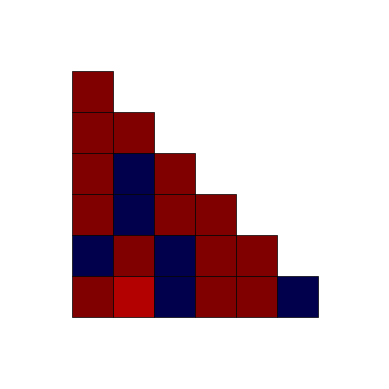

In [111]:
designs = DesignLEL(lattice, NparticleTypes)
visualisation = LELrepresentation(lattice, NparticleTypes)

affinity = 2
anisotropy = 10
LEL_random = designs.LEL_random(affinity, anisotropy)
LEL_random_short = designs.cut_LEL(LEL_random)


visualisation.plot_matrix(LEL_random_short, fullMatrix=False, maxi=10)

### 4.5 Implicit triangular particles

One type of triangular particles

In [181]:
designs = DesignLEL(lattice, 1)
visualisation = LELrepresentation(lattice, 1)

einf = 100
AA, BB, CC = -10, einf, einf
AC, AB = einf, einf
BC = -10

LEL_1triangle = designs.LEL_triangle_one_particle(AA, AB, AC, BC, BB, CC)

Two type of triangular particles. So far, this works but is not well coded and automatized. I need to check what Martin Flament did. 

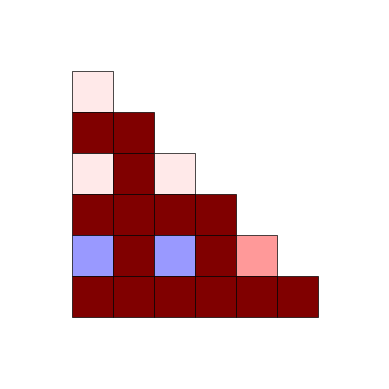

In [185]:
designs = DesignLEL(lattice, 2)
visualisation = LELrepresentation(lattice, 2)

einf = 100


energies = {}
energies['FF'] = -8
energies['LK'] = -10
energies['FL'] = 2
energies['LL'] = 2
energies['KK'] = 10
energies['FK'] = 10

LELlist = []
"""FFL LLK"""
A1A1, B1B1, C1C1 = 'FF', 'FF', 'LL'
A1C1, A1B1, B1C1 = 'FL', 'FF', 'FL'

A1A2, B1B2, C1C2 = 'FL', 'FL', 'LK'
A1C2, A1B2, B1C2 = 'FK', 'FL', 'FK'
A2C1, A2B1, B2C1 = 'LL', 'FL', 'LL'

A2A2, B2B2, C2C2 = 'LL','LL', 'KK'
A2C2, A2B2, B2C2 = 'LK', 'LL', 'LK'

elist_ref = [A1A1, B1B1, C1C1, 
A1C1, A1B1, B1C1,
A1A2, B1B2, C1C2,
A1C2, A1B2, B1C2,
A2C1, A2B1, B2C1,
A2A2, B2B2, C2C2,
A2C2, A2B2, B2C2]
elist_e = []

for e in elist_ref:
    elist_e.append(energies[e])
    
A1A1, B1B1, C1C1, A1C1, A1B1, B1C1,A1A2, B1B2, C1C2,A1C2, A1B2, B1C2,A2C1, A2B1, B2C1,A2A2, B2B2, C2C2,A2C2, A2B2, B2C2 = elist_e

LEL = designs.LEL_triangle_two_particle(A1A1, A1B1, A1C1, B1C1, B1B1, C1C1, 
                                  A1A2, A1B2, A1C2, B1C2, B1B2, C1C2,
                                  A2C1, A2B1, B2C1,
                                  A2A2, A2B2, A2C2, B2C2, B2B2, C2C2,
                                  einf=100)
LELlist.append(LEL)

"""FLK LLK"""
A1A1, B1B1, C1C1 = 'FF', 'LL', 'KK'
A1C1, A1B1, B1C1 = 'FK', 'FL', 'LK'

A1A2, B1B2, C1C2 = 'FL', 'LL', 'KK'
A1C2, A1B2, B1C2 = 'FK', 'FL', 'LK'
A2C1, A2B1, B2C1 = 'LK', 'LL', 'LK'

A2A2, B2B2, C2C2 = 'LL','LL', 'KK'
A2C2, A2B2, B2C2 = 'LK', 'LL', 'LK'

elist_ref = [A1A1, B1B1, C1C1, 
A1C1, A1B1, B1C1,
A1A2, B1B2, C1C2,
A1C2, A1B2, B1C2,
A2C1, A2B1, B2C1,
A2A2, B2B2, C2C2,
A2C2, A2B2, B2C2]
elist_e = []

for e in elist_ref:
    elist_e.append(energies[e])
    
A1A1, B1B1, C1C1, A1C1, A1B1, B1C1,A1A2, B1B2, C1C2,A1C2, A1B2, B1C2,A2C1, A2B1, B2C1,A2A2, B2B2, C2C2,A2C2, A2B2, B2C2 = elist_e

LEL_2triangle = designs.LEL_triangle_two_particle(A1A1, A1B1, A1C1, B1C1, B1B1, C1C1, 
                                  A1A2, A1B2, A1C2, B1C2, B1B2, C1C2,
                                  A2C1, A2B1, B2C1,
                                  A2A2, A2B2, A2C2, B2C2, B2B2, C2C2,
                                  einf=100)

visualisation.plot_matrix(designs.cut_LEL(LEL_2triangle), fullMatrix=False, p1=1, p2=1)


### 4.6 Camembert particles

Particles can be designed to assemble into camembert, or zig-zag fibers. It is also possible to have two types of particles, one neutral, and one that assembles into camembert, to introduce the particles progressively during the annealing by allowing mutation between particles types. 

For this specific particles, we reperesent the interaction matrix with a specific colormap, instead of the energy levels, but this is optional.

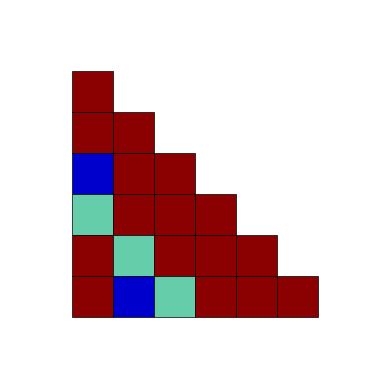

In [119]:
designs = DesignLEL(lattice, 1)
visualisation = LELrepresentation(lattice, 1)

ecrystal = -8.5+12#0.5
eline = -16+12 #-8
sigma = 6
sigma_unfav = 6
einf = 15
# # ez = 0
# # chiral = False

LEL_camembert = designs.LEL_camembert2D(ecrystal, eline, sigma, sigma_unfav, einf)
LEL_camembert_short = designs.cut_LEL(LEL_camembert)

# LEL = designs.LEL_camembert3D(ecrystal, eline, sigma, sigma_unfav, einf, ez, chiral)

LEL_fiberzigzag = designs.LEL_fiber_zigzag_2D(ecrystal, eline, sigma, sigma_unfav, einf)
LEL_fiberzigzag_short = designs.cut_LEL(LEL_fiberzigzag)

# LEL = designs.LEL_camembert2D_and_passive(ecrystal, eline, sigma, sigma_unfav, einf)


color_map_camembert = designs.get_colormap_camembert()
visualisation.plot_matrix(LEL_camembert_short, fullMatrix=False, colordict=color_map)

In [ ]:

"""Test mutation"""
# LEL = designs.LEL_change_population_two_particles(e1,e2)
# LELlist = [LEL]

### 4.7 Some specific aggregate geometries

Text(0.5, 1.0, 'crystallite')

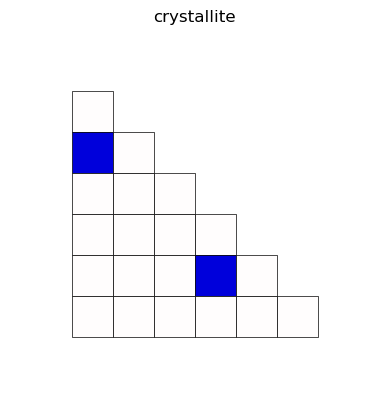

In [82]:
designs = DesignLEL(lattice, 1)
visualisation = LELrepresentation(lattice, 1)

examples_names = ['liquid', 'crystal', 'sponge_sparse', 'fiber_dimer','crystallite','micelle', 'cycle','gas']

i=4

stickiness=3
repulsion=0
LEL_example = designs.LEL_fixed_point(examples_names[i], stickiness, repulsion)   

visualisation.plot_matrix(designs.cut_LEL(LEL_example), maxi=10, fullMatrix=False)
plt.title(examples_names[i], fontsize=12)


### 4.8 Favor only some of the interactions

The LEL with n_fav favored interactions where all computed in a non-redundant way previously, and this has been saved in the "all_two_levels" files --> Ask me later if interested

In [175]:
n_fav=3
attractive = -10
repulsive = 0

#for i in range (134):
#     LEL_nfav = designs.LEL_two_levels_unique(n_fav, attractive, repulsive, i, local=False)

### 4.9 Choose the LEL manually
In this case, the function LEL_predetermined takes care of changing the size of the LEL to make it compatible with C++.

In [172]:
LEL_manual_short = np.array([  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1., -1., -5., -3., -2., -3., -3., -5., -4., -1.,
        -1., -3., -0.,  1.,  2.,  0., -0.,  0.,  3.])
LEL_manual = designs.LEL_predetermined(LEL_manual_short)

### 4.9 Choose the interaction matrices you want

In [112]:
#LELlist = [LEL_random, LEL_example, LEL_camembert]
LELlist = [LEL_random]

## 5. Write the parameters file

Frist create a dictionnary with all the parameters

In [113]:
lattice_name = lattice.name

if processLocal :
    directoryInputs = localDirectory + projectFolderName + "Lattice/"
    directoryResults = localDirectory + projectFolderName + "Results/"+  folderResults+"/"
    directoryInputsRead = localDirectory + projectFolderName + "Lattice/"
    directoryResultsRead = localDirectory + projectFolderName + "Results/"+  folderResults+"/"
        
else :
    directoryInputs = remoteDirectory + projectFolderName+ "Lattice/"
    directoryResults = remoteDirectoryScratch + projectFolderName + "Results/"+ folderResults+"/"
    directoryInputsRead = remoteFromLocalDirectory + projectFolderName+ "Lattice/"
    directoryResultsRead = remoteFromLocalDirectoryScratch + projectFolderName + "Results/"+ folderResults+"/"

myParameters={}  
    
"""Geometry of the system """
myParameters["lattice"]=lattice_name #string
myParameters["Lx"]=Lx #int
myParameters["Ly"]=Ly #int
myParameters["Lz"]=Lz #int
myParameters["firstNeighborDistance"] = firstNeighborDistance
myParameters["secondNeighborDistance"] = secondNeighborDistance


"""Composition of the system"""
myParameters["NparticleTypes"]= NparticleTypes #int
myParameters["Nparticles"]=Nparticles # list of int of the size NparticleTypes

"""Montecarlo rate"""
myParameters["FlipRate"] = flipRate
myParameters["SwapRate"] = swapRate
myParameters["FlipSwapRate"] = flipSwapRate
myParameters["MutationRate"] = mutationRate
#the sum has to be one 

"""Annealing parameters"""
myParameters["Nsteps_per_T"]=Nsteps_per_T #int
myParameters["Ntemperatures"]=Ntemperatures #int
myParameters["Temperature_start"]=Temperature_start #float
myParameters["Temperature_end"]=Temperature_end 
myParameters["Type_temperature_ramp"]=Type_temperature_ramp #string

"""Quenching parameters"""
myParameters["Nsteps_quenching"]=Nsteps_quenching #int
myParameters["Temperature_quenching"]=Temperature_quenching


"""Measurement parameters - equlibration info"""
myParameters["saveSnapshot"] = saveSnapshot #bool
myParameters["Nmes_per_T"] = N_mes_per_temperatures #number of snapshot along 
    # the annealing -> usually zero, unless you want to make videos
myParameters["saveTemperatures"] = saveTemperatures #bool
myParameters["saveEnergies"] = saveEnergies #bool
# if True, will save successive values of energy during the annealing, quenching, and statistics
myParameters["saveMCsuccess"] = saveMCsuccess


"""Measurement parameters - statistics about system composition"""
myParameters["doStatistics"] = doStatistics
myParameters["Temperature_statistics"]=Temperature_statistics
myParameters["Naverage"]=Naverage #int

myParameters["saveCovariance"] = saveCovariance 
myParameters["saveExtendedScaffold"] = saveExtendedScaffold# only useful for renormalisation


"""Measurement parameters - statistics about clusters"""
myParameters["Ncluster_measurements"]=Ncluster_measurements #int
myParameters["MC_steps_between_measurements"]=MC_steps_between_measurements

The functions that will save the parameters file and LEL file in the result folder.

In [9]:
def save_parameters_file(directoryResults, ide=None):
    directoryResults_mkdir = directoryResults
    directoryResults = directoryResults+str(ide)
    
    try :
        """We check if the parameter file exists already"""
        jsonFile = open(directoryResults+"input_parameters.json", "r")
        print('Parameters file '+directoryResults+"input_parameters.json"+' already exists\nWe do nothing')
        saved = False
    except:
        try :
            """The folder exists"""
            jsonFile = open(directoryResults+"input_parameters.json", "w")
        except :
            """We need to create the folder"""
            print('We create folder '+directoryResults)
            subprocess.run(['mkdir', directoryResults_mkdir])
            jsonFile = open(directoryResults+"input_parameters.json", "w")
            
        jsonFile.write(jsonString)
        jsonFile.close()
        saved = True
    return(saved)


def save_LEL_file(directoryResults, LEL):
    file_LEL=open(directoryResults+myParameters["LELfileSuffix"],'w')       
    energy_string=''
    for e in LEL:
        energy_string+=str(e)+' '
    energy_string+="#END"
    file_LEL.write(energy_string+"\n")       
    
   

## 6. Run the simulation
The function that uses subprocess to launch the C++ executable with the parameter file

In [ ]:
def launch_simu(directoryResults):
    try :
        open(directoryResults+"_LEL_chosen.txt", "r")
        already_done = True
    except :
        already_done = False
        
    if already_done :
        print(directoryResults, 'aldready ran')
    else :
        subprocess.run(["./Sys", directoryResults])    

In [114]:
i=0

for LEL in LELlist:
    
    """If you want the first temperature to scale like the maximal energy"""
    Temperature_start = np.max(np.abs(LEL))
        
    for n in range (i*Nsystems, (i+1)*Nsystems):
        
        """Saving parameters"""
        myParameters["directoryInputs"]=directoryInputs #string
        myParameters["directoryResults"]=directoryResults +str(n) #string
        myParameters["directoryResultsRead"]=directoryResultsRead +str(n)#string
        myParameters["directoryInputsRead"]=directoryInputsRead #string
        myParameters["LELfileSuffix"] = '_LEL.txt' #string
        
        """If you want the first temperature to scale like the maximal energy"""
        myParameters["Temperature_start"]=Temperature_start
        
        
        jsonString = json.dumps(myParameters)    
        saved = save_parameters_file(directoryResults ,n)
        save_LEL_file(directoryResults +str(n), LEL)
        launch_simu(directoryResults +str(n))
        
            
    i+=1


We create folder /Users/lara/Documents/SelfAssembly2/Results/231025Test2/0
Energies : 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 17.6415 -6.62333 7.39985 11.0359 17.4294 11.6013 -9.17084 15.6492 3.95096 19.3444 -9.0101 6.53554 -6.28045 -6.88708 7.55584 25.9206 21.2027 14.6404 11.395 15.8401 -6.18797 -13.5798 7.84321 -2.34712 -1.67555 5.11356 -4.16097 -3.78812 0.757836 -3.11182 3.18702 22.6761 -6.99217 4.97409 21.3209 10.5175 3.88133 10.9139 -11.7126 14.2135 -5.22633 -15.9469 4.7456 10.2075 12.086 0.422052 -1.4209 6.32956 -20.8927 9.95478 5.84763 -1.32848 9.34803 20.2494 14.4782 20.3561 10.0906 5.77106 9.08651 -10.014 -9.91576 7.66122 17.6556 -11.6855 1.95365 -2.32584 -6.4323 -5.67994 7.31651 0.741775 9.42674 11.6463 8.10308 -15.722 19.7639 16.5793 15.0071 -0.399577 


30*30*1 Triangular lattice is initialized: 0 seconds


The density of particles is 0.111111 -> 100 particles
Energy per particle : 1.29


Annealing: 245 seconds
Quenching: 0 seconds


Energy per particle : -18.78
Energy per particle : -18.78
3 clusters in this system
Energies : 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 17.6415 -6.62333 7.39985 11.0359 17.4294 11.6013 -9.17084 15.6492 3.95096 19.3444 -9.0101 6.53554 -6.28045 -6.88708 7.55584 25.9206 21.2027 14.6404 11.395 15.8401 -6.18797 -13.5798 7.84321 -2.34712 -1.67555 5.11356 -4.16097 -3.78812 0.757836 -3.11182 3.18702 22.6761 -6.99217 4.97409 21.3209 10.5175 3.88133 10.9139 -11.7126 14.2135 -5.22633 -15.9469 4.7456 10.2075 12.086 0.422052 -1.4209 6.32956 -20.8927 9.95478 5.84763 -1.32848 9.34803 20.2494 14.4782 20.3561 10.0906 5.77106 9.08651 -10.014 -9.91576 7.66122 17.6556 -11.6855 1.95365 -2.32584 -6.4323 -5.67994 7.31651 0.741775 9.42674 11.6463 8.10308 -15.722 19.7639 16.5793 15.0071 -0.399577 


Statistics during 720000 MC steps at T=1.000000kT: 19 seconds
Cluster measurements (1 measures): 0 seconds
Simulation duration: 267 seconds
30*30*1 Triangular lattice is initialized: 0 seconds


The density of particles is 0.111111 -> 100 particles
Energy per particle : 2.58


Annealing: 238 seconds
Quenching: 0 seconds


Energy per particle : -7.62
Energy per particle : -7.73
3 clusters in this system
Energies : 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 17.6415 -6.62333 7.39985 11.0359 17.4294 11.6013 -9.17084 15.6492 3.95096 19.3444 -9.0101 6.53554 -6.28045 -6.88708 7.55584 25.9206 21.2027 14.6404 11.395 15.8401 -6.18797 -13.5798 7.84321 -2.34712 -1.67555 5.11356 -4.16097 -3.78812 0.757836 -3.11182 3.18702 22.6761 -6.99217 4.97409 21.3209 10.5175 3.88133 10.9139 -11.7126 14.2135 -5.22633 -15.9469 4.7456 10.2075 12.086 0.422052 -1.4209 6.32956 -20.8927 9.95478 5.84763 -1.32848 9.34803 20.2494 14.4782 20.3561 10.0906 5.77106 9.08651 -10.014 -9.91576 7.66122 17.6556 -11.6855 1.95365 -2.32584 -6.4323 -5.67994 7.31651 0.741775 9.42674 11.6463 8.10308 -15.722 19.7639 16.5793 15.0071 -0.399577 


Statistics during 720000 MC steps at T=1.000000kT: 16 seconds
Cluster measurements (1 measures): 0 seconds
Simulation duration: 256 seconds
30*30*1 Triangular lattice is initialized: 0 seconds


The density of particles is 0.111111 -> 100 particles
Energy per particle : 1.66
Energy per particle : -32.14


Annealing: 217 seconds
Quenching: 0 seconds


Energy per particle : -32.14
2 clusters in this system
Energies : 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 17.6415 -6.62333 7.39985 11.0359 17.4294 11.6013 -9.17084 15.6492 3.95096 19.3444 -9.0101 6.53554 -6.28045 -6.88708 7.55584 25.9206 21.2027 14.6404 11.395 15.8401 -6.18797 -13.5798 7.84321 -2.34712 -1.67555 5.11356 -4.16097 -3.78812 0.757836 -3.11182 3.18702 22.6761 -6.99217 4.97409 21.3209 10.5175 3.88133 10.9139 -11.7126 14.2135 -5.22633 -15.9469 4.7456 10.2075 12.086 0.422052 -1.4209 6.32956 -20.8927 9.95478 5.84763 -1.32848 9.34803 20.2494 14.4782 20.3561 10.0906 5.77106 9.08651 -10.014 -9.91576 7.66122 17.6556 -11.6855 1.95365 -2.32584 -6.4323 -5.67994 7.31651 0.741775 9.42674 11.6463 8.10308 -15.722 19.7639 16.5793 15.0071 -0.399577 


Statistics during 720000 MC steps at T=1.000000kT: 16 seconds
Cluster measurements (1 measures): 0 seconds
Simulation duration: 234 seconds
30*30*1 Triangular lattice is initialized: 0 seconds


The density of particles is 0.111111 -> 100 particles
Energy per particle : 1.83


Annealing: 214 seconds
Quenching: 0 seconds


Energy per particle : -20.05
Energy per particle : -20.1
2 clusters in this system


Statistics during 720000 MC steps at T=1.000000kT: 16 seconds
Cluster measurements (1 measures): 0 seconds
Simulation duration: 232 seconds


## 7. Look at the results

### 7.1. Load the results
This uses the ReadSeveralSystems class

In [129]:
name = '231025Test'
#name = '231025Test2'
R = ReadSeveralSystems(name, local=True)

Load  /Users/lara/Documents/SelfAssembly2/Results/231025Test
15 Nsimu in this folder
1% loaded in 0.0 min
21% loaded in 0.0 min
41% loaded in 0.0 min
61% loaded in 0.0 min
81% loaded in 0.0 min


### 7.2. Visualize the system state 

It is possible to choose the representation of the particle's orientation (either colors or arrows, or triangles instead of hexagons if the simulation concerns triangular particles)

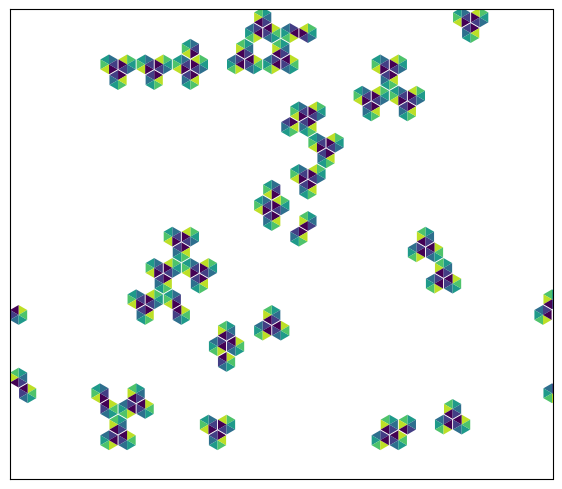

In [178]:
index = 0
representation = 'colored'#'colored' 'arrowed' 'triangle'
R.plot_state(index, representation=representation)

It is also possible to visualize the contacts between particles, colorcoded by their energy, or the type of the contacts through a specific colormap. 

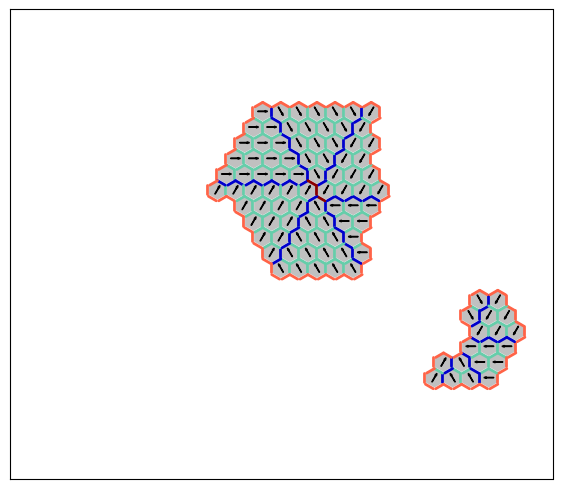

In [180]:
index = 10
color_map_contacts= color_map_camembert #None

R.plot_state(index, representation='arrowed', plot_contact=True, color_map_contacts=color_map_contacts)

### 7.3 Visualize the density map

Quantifies the proportion of first ($\mathbf{c}$) and second ($\mathbf{d}$) neighbors contacts.

Text(0.5, 1.0, 'Second neighbors contacts')

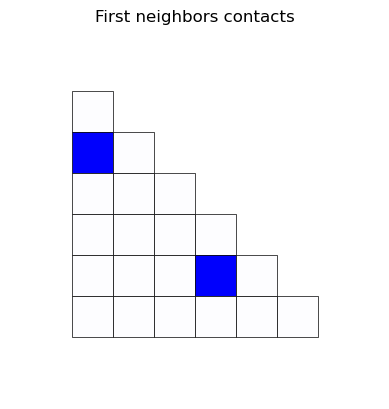

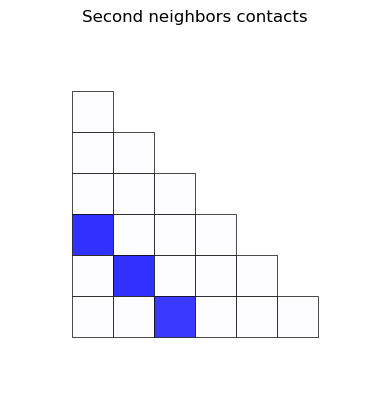

In [142]:
c, dc = R.measure('c', indices = range(5,10) )
d, dd = R.measure('d', indices = range(5,10) )

visualisation.plot_matrix(c, vectorIsLEL=False, fullMatrix=False, maxi=0.05)
plt.title('First neighbors contacts', fontsize=12)
visualisation.plot_matrix(d, vectorIsLEL=False, fullMatrix=False, maxi=0.05)
plt.title('Second neighbors contacts', fontsize=12)


### 7.4 Measure information about the cluster geometries 

In [169]:
R.load_cluster_statistics()
indices = range(5,10)


measures =  ['fullVolume','totalVolume' ,'sizeMax' ,
             'porosity','holeSize' ,'holesPerParticle',
             'savRatio','sphericity']
explanations = ['cluster size', 'cluster volume', 'maximal cluster size',
               'vacancies size per particle', 'average hole sizes', 'number of holes per particle',
                'surface to volume ratio', 'sphericity' ]


for k in range(len(measures)):
    x, dx = R.measure_cluster_information(measures[k],indices)
    print("The "+explanations[k]+" is "+str(round(x,2))+" +- "+str(round(dx,2))+"")


The cluster size is 62.7 +- 31.17
The cluster volume is 74.21 +- 37.17
The maximal cluster size is 78.8 +- 1.6
The vacancies size per particle is 0.15 +- 0.08
The average hole sizes is 1.03 +- 0.05
The number of holes per particle is 0.14 +- 0.07
The surface to volume ratio is 0.69 +- 0.56
The sphericity is 0.67 +- 0.16
